In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
import matplotlib.pyplot as plt


In [2]:
# NASDAQ Composite 31/01/2007 - 31/01/2023
# Dataset, NASDAQ_DATA.csv allegato alla mail Professore, da inserire nella prossima cella.
data = pd.read_csv("NASDAQ_DATA.csv")
prices = data["Close"].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
normalized_prices = scaler.fit_transform(prices)

# Creazione input-output sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i : i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 50
X, y = create_sequences(normalized_prices, window_size)

# Splitting del data set in training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


Epoch 1/20


2023-05-09 19:11:45.201419: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


100/100 [==============================] - 1s 10ms/step - loss: 0.0038 - val_loss: 0.0098
Epoch 2/20
100/100 [==============================] - 1s 9ms/step - loss: 4.2875e-05 - val_loss: 0.0048
Epoch 3/20
100/100 [==============================] - 1s 9ms/step - loss: 3.7825e-05 - val_loss: 0.0039
Epoch 4/20
100/100 [==============================] - 1s 9ms/step - loss: 3.5253e-05 - val_loss: 0.0040
Epoch 5/20
100/100 [==============================] - 1s 9ms/step - loss: 3.1722e-05 - val_loss: 0.0023
Epoch 6/20
100/100 [==============================] - 1s 9ms/step - loss: 3.0544e-05 - val_loss: 0.0027
Epoch 7/20
100/100 [==============================] - 1s 9ms/step - loss: 2.8139e-05 - val_loss: 0.0018
Epoch 8/20
100/100 [==============================] - 1s 9ms/step - loss: 3.0056e-05 - val_loss: 0.0016
Epoch 9/20
100/100 [==============================] - 1s 9ms/step - loss: 2.6534e-05 - val_loss: 0.0018
Epoch 10/20
100/100 [==============================] - 1s 9ms/step - loss: 2.4

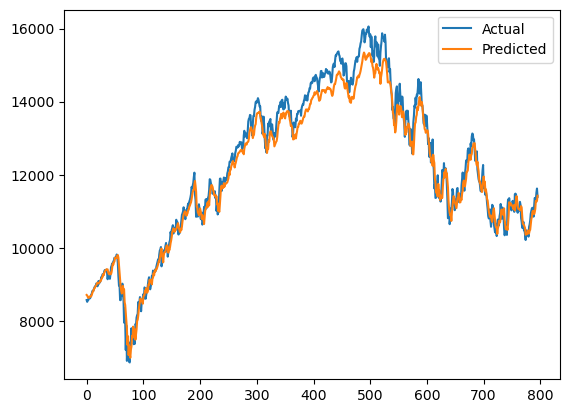

In [3]:
# Vanilla RNN

model = Sequential()
model.add(SimpleRNN(units=128, input_shape=(X_train.shape[1], 1), activation="tanh"))
model.add(Dense(1))

# Compilazione & Training del Vanilla RNN
model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluation
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

plt.plot(y_test_inv, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.legend()
plt.show()

In [4]:
# VanillaRNN Tuned

from keras_tuner import RandomSearch

# Funzione per creare model with tunable hyperparameters
def build_model(hp):
    model = Sequential()
    model.add(
        SimpleRNN(
            units=hp.Int("units", min_value=32, max_value=256, step=32),
            input_shape=(X_train.shape[1], 1),
            activation="tanh",
        )
    )
    model.add(Dense(1))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float("learning_rate", min_value=1e-5, max_value=1e-2, sampling="LOG")
        ),
        loss="mean_squared_error",
    )
    return model

# Tuner per Vanilla RNN
tuner = RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=10, 
    executions_per_trial=3,  
    directory="tuning_results",
    project_name="simplernn_tuning",
)

# Find the best hyperparameters
tuner.search(
    x=X_train,
    y=y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
)

INFO:tensorflow:Reloading Tuner from tuning_results/simplernn_tuning/tuner0.json
INFO:tensorflow:Oracle triggered exit


Epoch 1/20
100/100 [==============================] - 2s 18ms/step - loss: 3.1247e-05 - val_loss: 7.8574e-04
Epoch 2/20
100/100 [==============================] - 2s 18ms/step - loss: 2.2478e-05 - val_loss: 5.1702e-04
Epoch 3/20
100/100 [==============================] - 2s 17ms/step - loss: 2.1821e-05 - val_loss: 7.1702e-04
Epoch 4/20
100/100 [==============================] - 2s 17ms/step - loss: 2.4963e-05 - val_loss: 5.6070e-04
Epoch 5/20
100/100 [==============================] - 2s 17ms/step - loss: 2.3563e-05 - val_loss: 0.0014
Epoch 6/20
100/100 [==============================] - 2s 17ms/step - loss: 3.1607e-05 - val_loss: 4.3582e-04
Epoch 7/20
100/100 [==============================] - 2s 17ms/step - loss: 2.3529e-05 - val_loss: 3.5234e-04
Epoch 8/20
100/100 [==============================] - 2s 17ms/step - loss: 2.7121e-05 - val_loss: 0.0012
Epoch 9/20
100/100 [==============================] - 2s 17ms/step - loss: 3.0069e-05 - val_loss: 8.2230e-04
Epoch 10/20
100/100 [======

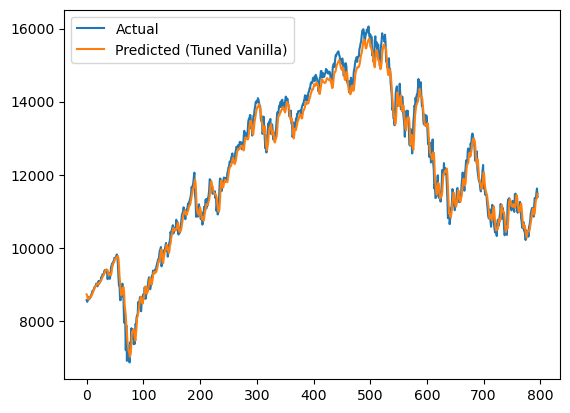

In [5]:
# Get the best model
best_model = tuner.get_best_models()[0] 
# Train the best model
best_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))
print(best_model.summary())

best_hps = tuner.get_best_hyperparameters()[0]
print("Best hyperparameters:")
print(f"Units: {best_hps.get('units')}")
print(f"Learning rate: {best_hps.get('learning_rate')}")



#  Layer (type)                Output Shape              Param #   
# =================================================================
#  simple_rnn (SimpleRNN)      (None, 160)               25920     
                                                                 
#  dense (Dense)               (None, 1)                 161       
                                                                 
# =================================================================
# Total params: 26,081
# Trainable params: 26,081
# Non-trainable params: 0
# _________________________________________________________________
# None
# Best hyperparameters:
# Units: 160
# Learning rate: 0.0005855095817167908

# Evaluation
y_pred_tuned = best_model.predict(X_test)
y_pred_tuned = scaler.inverse_transform(y_pred_tuned) 

# Plot the actual values and the predictions of the best model
plt.plot(y_test_inv, label="Actual")
plt.plot(y_pred_tuned, label="Predicted (Tuned Vanilla)")
plt.legend()
plt.show()

Epoch 1/20
100/100 [==============================] - 4s 26ms/step - loss: 0.0028 - val_loss: 3.6048e-04
Epoch 2/20
100/100 [==============================] - 2s 24ms/step - loss: 2.1329e-05 - val_loss: 3.4537e-04
Epoch 3/20
100/100 [==============================] - 2s 24ms/step - loss: 2.1557e-05 - val_loss: 3.2404e-04
Epoch 4/20
100/100 [==============================] - 2s 24ms/step - loss: 2.1091e-05 - val_loss: 3.4686e-04
Epoch 5/20
100/100 [==============================] - 2s 24ms/step - loss: 2.1028e-05 - val_loss: 3.0516e-04
Epoch 6/20
100/100 [==============================] - 2s 24ms/step - loss: 2.0162e-05 - val_loss: 2.9240e-04
Epoch 7/20
100/100 [==============================] - 2s 24ms/step - loss: 1.9423e-05 - val_loss: 3.4293e-04
Epoch 8/20
100/100 [==============================] - 2s 24ms/step - loss: 2.0143e-05 - val_loss: 2.7878e-04
Epoch 9/20
100/100 [==============================] - 2s 24ms/step - loss: 1.9604e-05 - val_loss: 2.7031e-04
Epoch 10/20
100/100 [==

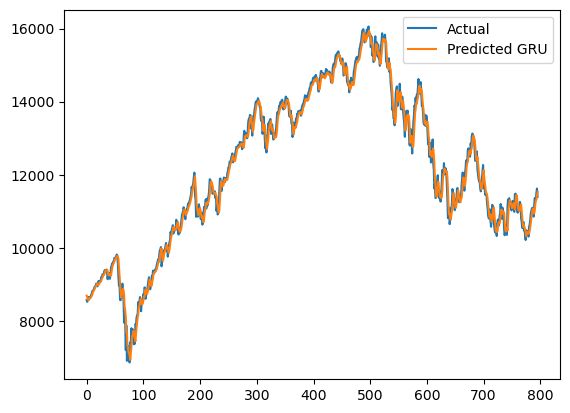

In [6]:
# Building del modello GRU

from tensorflow.keras.layers import GRU

model_gru = Sequential()
model_gru.add(GRU(units=128, input_shape=(X_train.shape[1], 1), activation="tanh"))
model_gru.add(Dense(1))

# Compilation del modello & Training
model_gru.compile(optimizer="adam", loss="mean_squared_error")
model_gru.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluation
y_pred_gru = model_gru.predict(X_test)
y_pred_gru = scaler.inverse_transform(y_pred_gru)
y_test_inv = scaler.inverse_transform(y_test)

plt.plot(y_test_inv, label="Actual")
plt.plot(y_pred_gru, label="Predicted GRU")
plt.legend()
plt.show()

In [7]:
# Tuned GRU

def build_model(hp):
    model = Sequential()
    model.add(
        GRU(
            units=hp.Int("units", min_value=32, max_value=256, step=32),
            input_shape=(X_train.shape[1], 1),
            activation="tanh",
        )
    )
    model.add(Dense(1))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float("learning_rate", min_value=1e-5, max_value=1e-2, sampling="LOG")
        ),
        loss="mean_squared_error",
    )
    return model

tuner = RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=10,  
    executions_per_trial=3,
    directory="tuning_results",
    project_name="gru_tuning",
)

tuner.search(
    x=X_train,
    y=y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
)


INFO:tensorflow:Reloading Tuner from tuning_results/gru_tuning/tuner0.json
INFO:tensorflow:Oracle triggered exit


Epoch 1/20
100/100 [==============================] - 3s 23ms/step - loss: 1.7992e-05 - val_loss: 3.3072e-04
Epoch 2/20
100/100 [==============================] - 2s 20ms/step - loss: 1.9697e-05 - val_loss: 2.5422e-04
Epoch 3/20
100/100 [==============================] - 2s 20ms/step - loss: 1.8061e-05 - val_loss: 2.5142e-04
Epoch 4/20
100/100 [==============================] - 2s 20ms/step - loss: 1.7865e-05 - val_loss: 2.4329e-04
Epoch 5/20
100/100 [==============================] - 2s 20ms/step - loss: 1.8245e-05 - val_loss: 3.0437e-04
Epoch 6/20
100/100 [==============================] - 2s 20ms/step - loss: 1.7366e-05 - val_loss: 2.6007e-04
Epoch 7/20
100/100 [==============================] - 2s 21ms/step - loss: 1.6471e-05 - val_loss: 2.9314e-04
Epoch 8/20
100/100 [==============================] - 2s 20ms/step - loss: 1.6480e-05 - val_loss: 2.3116e-04
Epoch 9/20
100/100 [==============================] - 2s 20ms/step - loss: 1.6146e-05 - val_loss: 2.3056e-04
Epoch 10/20
100/100

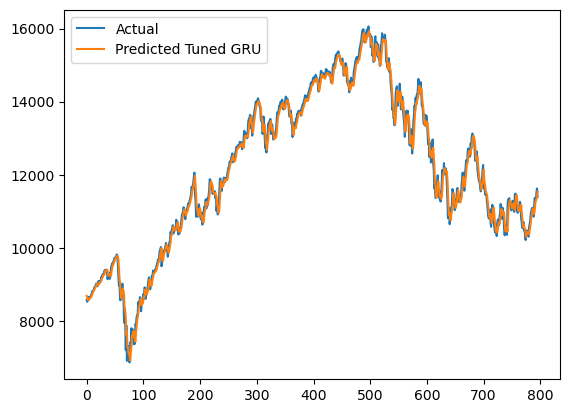

In [8]:
best_model_gru = tuner.get_best_models()[0]

best_model_gru.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

best_hps_gru = tuner.get_best_hyperparameters()[0] #corretto come sopra, senza il riferimento

print("Best hyperparameters:")
print(f"Units: {best_hps_gru.get('units')}")
print(f"Learning rate: {best_hps_gru.get('learning_rate')}")


best_model_gru.summary()

# Evaluation
y_pred_gru_tuned = best_model_gru.predict(X_test)
y_pred_gru_tuned = scaler.inverse_transform(y_pred_gru_tuned)
y_test_inv = scaler.inverse_transform(y_test)

plt.plot(y_test_inv, label="Actual")
plt.plot(y_pred_gru_tuned, label="Predicted Tuned GRU")
plt.legend()
plt.show()

Epoch 1/20
100/100 [==============================] - 4s 28ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 2/20
100/100 [==============================] - 3s 26ms/step - loss: 4.5039e-05 - val_loss: 7.1399e-04
Epoch 3/20
100/100 [==============================] - 3s 26ms/step - loss: 4.4151e-05 - val_loss: 6.6495e-04
Epoch 4/20
100/100 [==============================] - 3s 26ms/step - loss: 4.5956e-05 - val_loss: 6.5271e-04
Epoch 5/20
100/100 [==============================] - 3s 26ms/step - loss: 4.2944e-05 - val_loss: 6.2590e-04
Epoch 6/20
100/100 [==============================] - 3s 26ms/step - loss: 4.2129e-05 - val_loss: 7.1290e-04
Epoch 7/20
100/100 [==============================] - 3s 26ms/step - loss: 4.3714e-05 - val_loss: 8.5416e-04
Epoch 8/20
100/100 [==============================] - 3s 26ms/step - loss: 4.0700e-05 - val_loss: 5.7814e-04
Epoch 9/20
100/100 [==============================] - 3s 26ms/step - loss: 3.9716e-05 - val_loss: 5.6376e-04
Epoch 10/20
100/100 [======

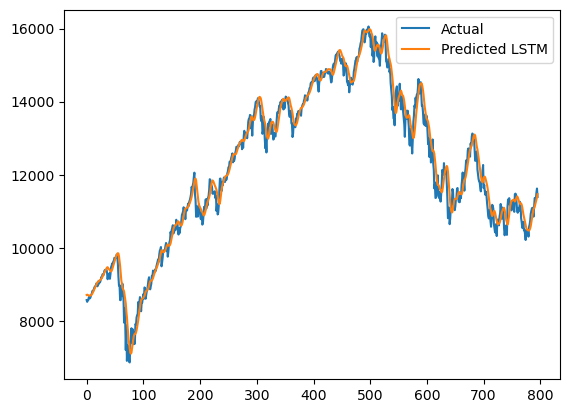

In [9]:
# LSTM

from tensorflow.keras.layers import LSTM

model_lstm = Sequential()
model_lstm.add(LSTM(units=128, input_shape=(X_train.shape[1], 1), activation="tanh"))
model_lstm.add(Dense(1))

# Training
model_lstm.compile(optimizer="adam", loss="mean_squared_error")
model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluation
y_pred_lstm = model_lstm.predict(X_test)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)
y_test_inv = scaler.inverse_transform(y_test)

plt.plot(y_test_inv, label="Actual")
plt.plot(y_pred_lstm, label="Predicted LSTM")
plt.legend()
plt.show()

In [10]:
# Tuned hyperparametri per LSTM

def build_model(hp):
    model = Sequential()
    model.add(
        LSTM(
            units=hp.Int("units", min_value=32, max_value=256, step=32),
            input_shape=(X_train.shape[1], 1),
            activation="tanh",
        )
    )
    model.add(Dense(1))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float("learning_rate", min_value=1e-5, max_value=1e-2, sampling="LOG")
        ),
        loss="mean_squared_error",
    )
    return model

# Setting up the tuner
lstm_tuner = RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=10,  
    executions_per_trial=3,  
    directory="tuning_results",
    project_name="lstm_tuning",
)

# Trovare best hyperparameters per LSTM
lstm_tuner.search(
    x=X_train,
    y=y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
)


INFO:tensorflow:Reloading Tuner from tuning_results/lstm_tuning/tuner0.json
INFO:tensorflow:Oracle triggered exit


Epoch 1/20
100/100 [==============================] - 3s 23ms/step - loss: 1.9430e-05 - val_loss: 2.6153e-04
Epoch 2/20
100/100 [==============================] - 2s 21ms/step - loss: 1.7851e-05 - val_loss: 2.6049e-04
Epoch 3/20
100/100 [==============================] - 2s 21ms/step - loss: 1.6968e-05 - val_loss: 2.6672e-04
Epoch 4/20
100/100 [==============================] - 2s 21ms/step - loss: 1.7620e-05 - val_loss: 2.5744e-04
Epoch 5/20
100/100 [==============================] - 2s 21ms/step - loss: 1.7525e-05 - val_loss: 3.0938e-04
Epoch 6/20
100/100 [==============================] - 2s 21ms/step - loss: 1.6908e-05 - val_loss: 2.4003e-04
Epoch 7/20
100/100 [==============================] - 2s 21ms/step - loss: 1.6682e-05 - val_loss: 2.4003e-04
Epoch 8/20
100/100 [==============================] - 2s 21ms/step - loss: 1.6797e-05 - val_loss: 2.4893e-04
Epoch 9/20
100/100 [==============================] - 2s 21ms/step - loss: 1.7023e-05 - val_loss: 2.8691e-04
Epoch 10/20
100/100

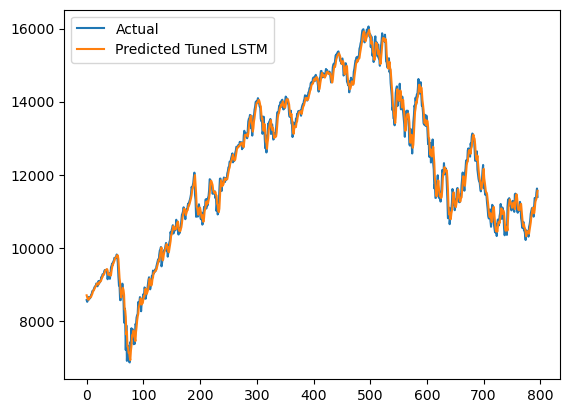

In [11]:
# Utilizzare e trovare migliori parameter, ergo nodi ecc. per modello LSTM
best_model_lstm = tuner.get_best_models()[0]

# Inoltre train the best model
best_model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

best_hps_lstm = tuner.get_best_hyperparameters()[0]

print("Best hyperparameters:")
print(f"Units: {best_hps_lstm.get('units')}")
print(f"Learning rate: {best_hps_lstm.get('learning_rate')}")


best_model_lstm.summary()

# Evaluation
y_pred_lstm_tuned = best_model_lstm.predict(X_test)
y_pred_lstm_tuned = scaler.inverse_transform(y_pred_lstm_tuned) 

plt.plot(y_test_inv, label="Actual")
plt.plot(y_pred_lstm_tuned, label="Predicted Tuned LSTM")
#plt.plot(y_pred_lstm      , label="Predicted")

plt.legend()
plt.show()

In [12]:
#  Metrics per ogni modello, ergo MAE,MSE,RMSE, MAPE, SMAPE, MDAPE

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


metrics = []
model_names = ["Vanilla RNN", "GRU", "LSTM", "Tuned RNN", "Tuned GRU", "Tuned LSTM"]
predictions = [y_pred, y_pred_gru, y_pred_lstm, y_pred_tuned, y_pred_gru_tuned, y_pred_lstm_tuned  ]



for model_name, y_pred_model in zip(model_names, predictions):
    mae = mean_absolute_error(y_test_inv, y_pred_model)
    mse = mean_squared_error(y_test_inv, y_pred_model)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test_inv, y_pred_model)
    smape =  np.mean((2 * np.abs(y_pred_model - y_test_inv) / (np.abs(y_pred_model) + np.abs(y_test_inv))))
    mdape = np.median((np.abs(np.subtract(y_test_inv, y_pred_model)/ y_test_inv)))
    metrics.append([model_name, mae, mse, rmse, mape, smape, mdape])

column_names = ["Model", "MAE", "MSE", "RMSE", "MAPE", "SMAPE", "MDAPE"]
results_df = pd.DataFrame(metrics, columns=column_names)

results_df.to_csv("metrics_performance.csv")


print(results_df)

         Model         MAE            MSE        RMSE      MAPE     SMAPE   
0  Vanilla RNN  281.556615  124262.068807  352.508254  0.022381  0.022573  \
1          GRU  173.121854   49156.578260  221.712828  0.014705  0.014695   
2         LSTM  232.583115   96688.198428  310.947260  0.019995  0.019783   
3    Tuned RNN  205.368620   65763.945131  256.444819  0.017028  0.017056   
4    Tuned GRU  169.559932   47074.275621  216.966070  0.014403  0.014402   
5   Tuned LSTM  165.061290   45865.260593  214.161763  0.014069  0.014039   

      MDAPE  
0  0.019865  
1  0.012030  
2  0.014375  
3  0.014812  
4  0.011792  
5  0.010986  


In [13]:
pred_actual = np.hstack((y_test_inv, y_pred, y_pred_gru, y_pred_lstm, y_pred_tuned, y_pred_gru_tuned, y_pred_lstm_tuned))
column_names1 = ["Actual","Vanilla RNN", "GRU", "LSTM", "Tuned RNN", "Tuned GRU", "Tuned LSTM"]
pred_actualdf = pd.DataFrame(data=pred_actual, columns=column_names1)

# pred_actualdf.to_csv("pred.csv")

pred_actualdf['Return_Actual'] = np.log(pred_actualdf['Actual'] / pred_actualdf['Actual'].shift(1))
pred_actualdf['Return_RNN']    = np.log(pred_actualdf['Vanilla RNN'] / pred_actualdf['Vanilla RNN'].shift(1))
pred_actualdf['Return_GRU']    = np.log(pred_actualdf['GRU'] / pred_actualdf['GRU'].shift(1))
pred_actualdf['Return_LSTM']   = np.log(pred_actualdf['LSTM'] / pred_actualdf['LSTM'].shift(1))
pred_actualdf['Return_Tuned_RNN']    = np.log(pred_actualdf['Tuned RNN'] / pred_actualdf['Tuned RNN'].shift(1))
pred_actualdf['Return_Tuned_GRU']    = np.log(pred_actualdf['Tuned GRU'] / pred_actualdf['Tuned GRU'].shift(1))
pred_actualdf['Return_Tuned_LSTM']   = np.log(pred_actualdf['Tuned LSTM'] / pred_actualdf['Tuned LSTM'].shift(1))

pred_act_df = pred_actualdf.dropna() 

In [14]:
# Calculation of the metrics per i returns


metrics_ret = []
model_names = ["Vanilla RNN", "GRU", "LSTM", "Tuned RNN", "Tuned GRU", "Tuned LSTM"]
pred_columns = ['Return_RNN', 'Return_GRU', 'Return_LSTM', "Return_Tuned_RNN", "Return_Tuned_GRU", "Return_Tuned_LSTM"]


# Il loop per calcolarei metrics del return 
for model_name, pred_col in zip(model_names, pred_columns):
    y_true = pred_act_df['Return_Actual']
    y_predicted = pred_act_df[pred_col]
    mae = mean_absolute_error(y_true, y_predicted)
    mse = mean_squared_error(y_true, y_predicted)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_predicted)
    smape =  np.mean((2 * np.abs(y_predicted - y_true) / (np.abs(y_predicted) + np.abs(y_true))))
    mdape = np.median((np.abs(np.subtract(y_true, y_predicted)/ y_true)))
    metrics_ret.append([model_name, mae, mse, rmse, mape, smape, mdape])  
    

column_names = ["Model", "MAE", "MSE", "RMSE", "MAPE", "SMAPE", "MDAPE"]
results_ret_df = pd.DataFrame(metrics_ret, columns=column_names)

print(results_ret_df)
# In questo caso MAPE, SMAPE e MDAPE sono meno attendibili in quanto i return sono vicini a zero.
# Quindi i valori tendono a infinito. Mentre MAE, MSE e RMSE sono molto migliorati

         Model       MAE       MSE      RMSE      MAPE     SMAPE     MDAPE
0  Vanilla RNN  0.015413  0.000485  0.022031  5.115352  1.475245  1.160928
1          GRU  0.015251  0.000470  0.021681  6.021121  1.437872  1.179240
2         LSTM  0.013794  0.000383  0.019580  3.393590  1.486023  1.059556
3    Tuned RNN  0.015031  0.000444  0.021067  5.609737  1.450854  1.141659
4    Tuned GRU  0.015591  0.000493  0.022208  6.386927  1.437593  1.206613
5   Tuned LSTM  0.015591  0.000493  0.022210  6.386996  1.437558  1.206309


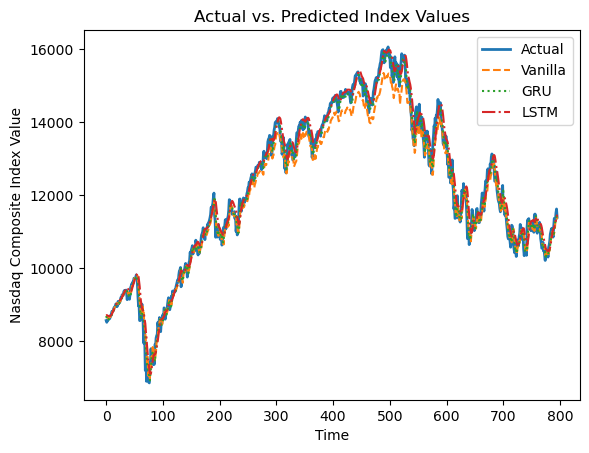

In [15]:
# Plot modelli pre-tuning

plt.plot(y_test_inv, label="Actual", linewidth=2)

plt.plot(y_pred, label="Vanilla", linestyle="--")
plt.plot(y_pred_gru, label="GRU", linestyle=":")
plt.plot(y_pred_lstm, label="LSTM", linestyle="-.")

plt.xlabel("Time")
plt.ylabel("Nasdaq Composite Index Value")
plt.title("Actual vs. Predicted Index Values")
plt.legend()

plt.show()

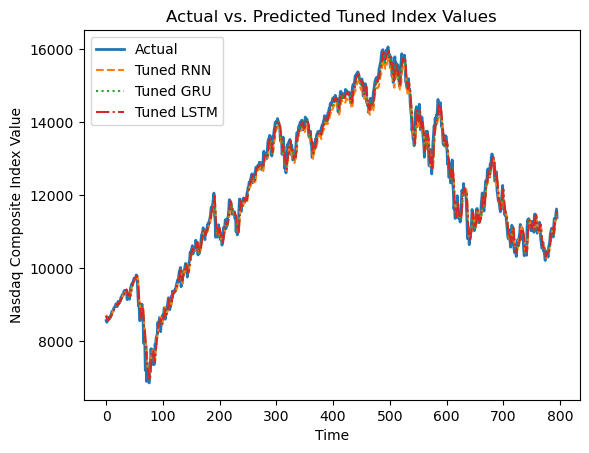

In [16]:
# Plot nuovi valori tuned, deviazione tra tuned e actual è migliorata dopo il hyperparameter tuning

import matplotlib.pyplot as plt

plt.plot(y_test_inv, label="Actual", linewidth=2)

plt.plot(y_pred_tuned, label="Tuned RNN", linestyle="--")
plt.plot(y_pred_gru_tuned, label="Tuned GRU", linestyle=":")
plt.plot(y_pred_lstm_tuned, label="Tuned LSTM", linestyle="-.")

plt.xlabel("Time")
plt.ylabel("Nasdaq Composite Index Value")
plt.title("Actual vs. Predicted Tuned Index Values")
plt.legend()

plt.show()

In [17]:
# Computing the same sign percentage for each pair of columns

# Funzione to compute per the percentage of same sign values in two columns
def same_sign_percentage(column1, column2):
    same_signs = (column1 * column2) > 0
    return same_signs.sum() / len(column1)

name_columns = ['Return_Actual','Return_RNN', 'Return_GRU', 'Return_LSTM', "Return_Tuned_RNN", "Return_Tuned_GRU", "Return_Tuned_LSTM"]

df = pred_actualdf[name_columns]


same_sign_percentage_results = pd.DataFrame(index=df.columns, columns=df.columns)

for col1 in df.columns:
    for col2 in df.columns:
        if col1 == col2:
            same_sign_percentage_results.loc[col1, col2] = 1
        else:
            same_sign_percentage_results.loc[col1, col2] = same_sign_percentage(df[col1], df[col2])

print(same_sign_percentage_results)

# Prima riga -> la previsione dei return di LSTM in termini di direzione (su/giu') e' coerente con circa
# i return nel 51.8% dei casi.   
# Ma si dovrebbe poter migliorare con il parameter tuning. --> Hyperparameter Tuning sotto ogni modello 
# Hyperparameter tuning --> nuovi plot e risultati presentati above


                  Return_Actual Return_RNN Return_GRU Return_LSTM   
Return_Actual                 1   0.497487   0.507538    0.527638  \
Return_RNN             0.497487          1   0.797739    0.722362   
Return_GRU             0.507538   0.797739          1    0.752513   
Return_LSTM            0.527638   0.722362   0.752513           1   
Return_Tuned_RNN        0.51005   0.797739   0.898241    0.755025   
Return_Tuned_GRU       0.507538   0.780151    0.96608    0.742462   
Return_Tuned_LSTM      0.507538   0.780151    0.96608    0.742462   

                  Return_Tuned_RNN Return_Tuned_GRU Return_Tuned_LSTM  
Return_Actual              0.51005         0.507538          0.507538  
Return_RNN                0.797739         0.780151          0.780151  
Return_GRU                0.898241          0.96608           0.96608  
Return_LSTM               0.755025         0.742462          0.742462  
Return_Tuned_RNN                 1         0.873116          0.873116  
Return_Tuned_GR